PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
     PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch      Ticket  \
886          887         0       2    male  27.0      0      0      211536   
887          888         1       1  female  19.0      0      0      112053   
888          889         0       3  female   NaN      1      2  W./C. 6607   
889          890         1       1    male  26.0      0      0      111369   
890          891         0       3    male  32.0      0      0      370376   

      Fare Embarked     Deck    Title  
886  13.00        S  Unknown

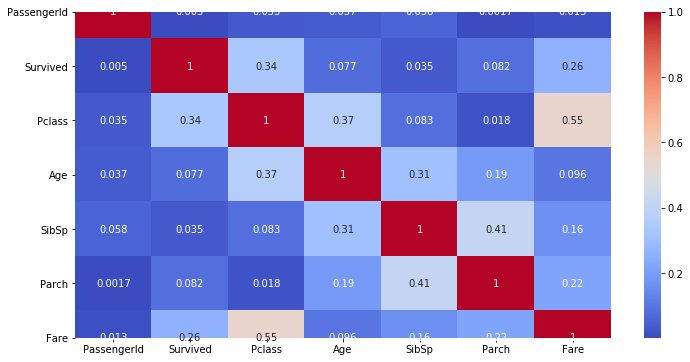

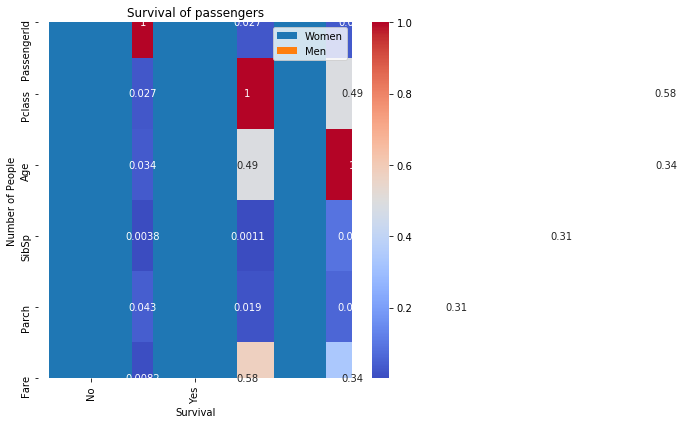

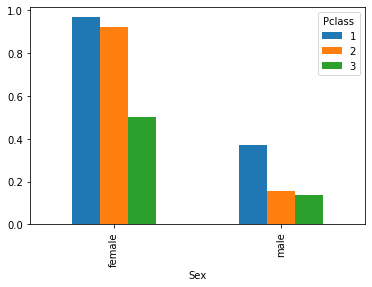

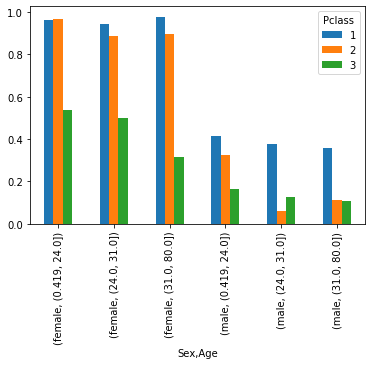

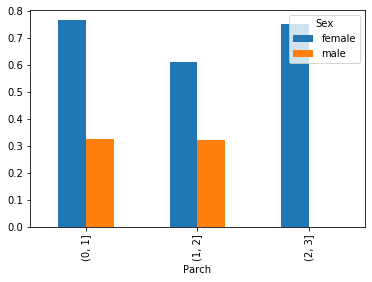

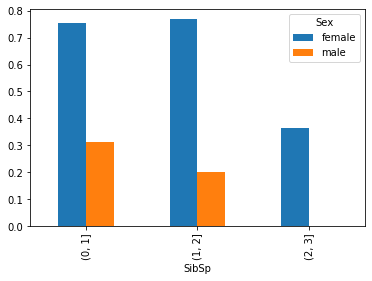

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.metrics import accuracy_score

training_set = pd.read_csv('C:/Users/subar/Downloads/CMPE-255 Sec 99 - Data Mining/Home Works/HW3_Submission/train.csv')
test_set = pd.read_csv('C:/Users/subar/Downloads/CMPE-255 Sec 99 - Data Mining/Home Works/HW3_Submission/test.csv')
training_set.head()

print(training_set.isnull().sum())

print(test_set.isnull().sum())

#Cabin to Deck
# make a list of all the posible Decks, the last element is used when no cabin code is present
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
#define a function that replaces the cabin code with the deck character
def search_substring(big_string, substring_list):
    for substring in substring_list:
        if substring in big_string:
            return substring
    return substring_list[-1]

# replace passenger's name with his/her title (Mr, Mrs, Miss, Master)
def get_title(string):
    import re
    regex = re.compile(r'Mr|Don|Major|Capt|Jonkheer|Rev|Col|Dr|Mrs|Countess|Dona|Mme|Ms|Miss|Mlle|Master', re.IGNORECASE)
    results = regex.search(string)
    if results != None:
        return(results.group().lower())
    else:
        return(str(np.nan))

# dictionary to map to generate the new feature vector
title_dictionary = {
    "capt":"Officer",
    "col":"Officer",
    "major":"Officer",
    "dr":"Officer",
    "jonkheer":"Royalty",
    "rev":"Officer",
    "countess":"Royalty",
    "dona":"Royalty",
    "lady":"Royalty",
    "don":"Royalty",
    "mr":"Mr",
    "mme":"Mrs",
    "ms":"Mrs",
    "mrs":"Mrs",
    "miss":"Miss",
    "mlle":"Miss",
    "master":"Master",
    "nan":"Mr"
}

training_set['Deck'] = training_set['Cabin'].map(lambda x: search_substring(str(x), cabin_list))
test_set['Deck'] = test_set['Cabin'].map(lambda x: search_substring(str(x), cabin_list))
# delete the Cabin feature
training_set.drop('Cabin', 1, inplace=True)
test_set.drop('Cabin', 1, inplace=True)

training_set['Title'] = training_set['Name'].apply(get_title)
test_set['Title'] = test_set['Name'].apply(get_title)
training_set['Title'] = training_set['Title'].map(title_dictionary)
test_set['Title'] = test_set['Title'].map(title_dictionary)
# delete the Name feature
training_set.drop('Name', 1, inplace=True)
test_set.drop('Name', 1, inplace=True)

print(training_set.tail())

#dropping ticket column
training_set.drop('Ticket', 1, inplace=True)
test_set.drop('Ticket', 1, inplace=True)

all_data = [training_set,test_set]
for df in all_data:
    data_corr = df.corr().abs()
    plt.figure(figsize=(12, 6))
    sns.heatmap(data_corr, annot=True,cmap='coolwarm')
    #plt.show()

#mean - median --change
median_title = training_set.groupby(['Title'])['Age'].median()

title_list = ['Mr', 'Miss', 'Mrs', 'Master', 'Royalty', 'Officer']


def age_nan_replace(medians, dframe, title_list):
    for title in title_list:
        temp = dframe['Title'] == title  # extract indices of samples with same title
        dframe.loc[temp, 'Age'] = dframe.loc[temp, 'Age'].fillna(medians[title])  # replace nan values for mean


age_nan_replace(median_title, training_set, title_list)
age_nan_replace(median_title, test_set, title_list)

training_set.groupby('Embarked').size().plot(kind='bar')

# change mean to median
training_set['Embarked'].fillna('S', inplace=True)
test_set['Embarked'].fillna('S', inplace=True)
#fill the fare column in the test set
test_set['Fare'].fillna(test_set['Fare'].median(), inplace=True)

print(training_set.head())

index = training_set['Survived'].unique() # get the number of bars
grouped_data = training_set.groupby(['Survived', 'Sex'])
temp = grouped_data.size().unstack()
women_stats = (temp.iat[0,0], temp.iat[1,0])
men_stats = (temp.iat[0,1], temp.iat[1,1])
p1 = plt.bar(index, women_stats)
p2 = plt.bar(index, men_stats, bottom=women_stats)
plt.xticks(index, ('No', 'Yes'))
plt.ylabel('Number of People')
plt.xlabel('Survival')
plt.title('Survival of passengers')
plt.legend((p1[0], p2[0]), ('Women', 'Men'))
plt.tight_layout()

training_set.pivot_table('Survived',index='Sex',columns='Pclass').plot(kind='bar')

age_intervals = pd.qcut(training_set['Age'], 3)
training_set.pivot_table('Survived', ['Sex', age_intervals], 'Pclass').plot(kind='bar')
parch_intervals = pd.cut(training_set['Parch'], [0,1,2,3])
sibsp_intervals = pd.cut(training_set['SibSp'], [0,1,2,3])
training_set.pivot_table('Survived', parch_intervals, 'Sex').plot(kind='bar')

training_set['Family Size'] = training_set['Parch'] + training_set['SibSp']
test_set['Family Size'] = test_set['Parch'] + test_set['SibSp']
training_set.drop('Parch', axis=1, inplace=True)
training_set.drop('SibSp', axis=1, inplace=True)
test_set.drop('Parch', axis=1, inplace=True)
test_set.drop('SibSp', axis=1, inplace=True)
training_set.head()



numericals_list = ['Age','Fare']
for column in numericals_list:
    sc = StandardScaler(with_mean=True, with_std=True)
#    print(training_set[column].size)
#    print(test_set[column].size)
    sc.fit(training_set[column].values.reshape(-1,1))
    training_set[column] = sc.transform(training_set[column].values.reshape(-1,1))
    test_set[column] = sc.transform(test_set[column].values.reshape(-1,1))

training_set.pivot_table('Survived', sibsp_intervals, 'Sex').plot(kind='bar')

categorical_classes_list = ['Deck','Title','Embarked','Sex']
#encode features that are cateorical classes
encoding_list = []
for column in categorical_classes_list:
    le = LabelEncoder()
    le.fit(training_set[column])
    encoding_list.append(training_set[column].unique())
    encoding_list.append(list(le.transform(training_set[column].unique())))
    training_set[column] = le.transform(training_set[column])
    test_set[column] = le.transform(test_set[column])

# change: Encoding categorical values of ‘Emarked’, ‘Sex’, ‘Title’ of into numerical data using map() [Unlike LabelCoding of above]
#training_set['Embarked'] = training_set['Embarked'].map({'C':0, 'Q':1, 'S':2})
#training_set['Sex'] = training_set['Sex'].map({'male':0, 'female':1})
#training_set['Title'] = training_set['Title'].map({'Master':0,'Miss':1,'Mr':2,'Mrs':3,'Others':4})

print(training_set.head())
training_set = pd.get_dummies(training_set, columns=['Embarked','Pclass','Title', 'Deck'])
print(training_set.head())
test_set = pd.get_dummies(test_set, columns=['Embarked','Pclass','Title', 'Deck'])
print(test_set.head())
'''
training_set = pd.get_dummies(training_set, columns=['Embarked','Pclass','Title', 'Deck'])
test_set = pd.get_dummies(test_set, columns=['Embarked','Pclass','Title', 'Deck'])
'''


training_set, test_set = training_set.align(test_set, axis=1)
#test_set.drop('Survived', axis=1, inplace=True)
test_set.fillna(0, axis=1, inplace=True)



In [6]:
#test_set.fillna(0, inplace=True)
y = training_set['Survived'].values
X = training_set.drop(['Survived','PassengerId'], axis=1).values
X_test = test_set.drop(['Survived','PassengerId'], axis=1).values
y_test = test_set['Survived'].values





In [7]:
from sklearn import svm
from sklearn.metrics import accuracy_score

model_svm_l = svm.SVC(kernel='linear', C=0.1, gamma=0.1)
model_svm_l.fit(X, y)
prediction_svm_l = model_svm_l.predict(X_test)
print('The accuracy of the Linear Support Vector Machine is ', accuracy_score(prediction_svm_l, y_test))

The accuracy of the Linear Support Vector Machine is  0.631578947368421


In [8]:
model = LogisticRegression()
model.fit(X,y)
predictions = model.predict(X_test)
# Accuracy calculation
print('Accuracy with down sampled data:',(accuracy_score(y_test, predictions) * 100) ,"%")

Accuracy with down sampled data: 61.004784688995215 %


c:\users\subar\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
